## Getting started with bombcell

#### Install bombcell

Create a conda environment
```bash
conda create -n bombcell python=3.11
conda activate bombcell
```
Clone latest bombcell repository from github
```bash
git clone https://github.com/Julie-Fabre/bombcell.git
```
Install bombcell from local repository
```bash
cd bombcell/pyBombCell
# you could do `pip install .`, but uv is much quicker!
pip install uv
uv pip install . # or uv pip install -e . (-e for editable mode)
```

#### Setting up bombcell
##### Importing packages

In [1]:
import os, sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt

In [2]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

In [3]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

##### Defining data paths and getting bombcell parameters

By default: path to BombCell's toy dataset

In [4]:
# Replace with your kilosort directory
ks_dir = "toy_data"

# Set bombcell's output directory
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: toy_data


In [ ]:
## For Neuropixels probes, provide raw and meta files
# Leave 'None' if no raw data
raw_file_path = None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin" # ks_dir
meta_file_path = None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0.imec0.ap.meta"
param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  raw_file=raw_file_path,
                                  kilosort_version=2)

print("Bombcell parameters:")
pprint(param)

Bombcell parameters:
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 1e-05,
 'ephysKilosortPath': 'toy_data',
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin ': 20,
 'keep_only_somatic': True,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'minAmplitude': 40,
 'minNumSpikes': 300,
 'minPresenceRatio': 0.7,
 'minSNR': 5,
 'minSpatialDecaySlope': -0.008,
 'minSpatialDecaySlopeExp': 0.01,
 'minThreshDetectPeaksTroughs': 0.2

In [6]:
## For non-Neuropixels probes, provide raw files AND specify conversion factor to uV
# raw_file_path = "" # .bin, .dat...
# param = bc.get_default_parameters(ks_dir, 
#                                   raw_file=raw_file_path,
#                                   meta_file=meta_file_path)

# print("BombCell parameters:")
# pprint(param)
# param["gain_to_uV"] = None # needs to be passed explicitly to bc.get_default_parameters
# param["ephys_sampling_rate"] = 30_000
# param["nChannels"] = 385
# param["nSyncChannels"] = 1

##### Optionally, customize parameters (more on this later, below)

In [7]:
# for instance, you might to change classification thresholds like: 
# param["maxRPVviolations"] = 0.1
#  or which quality metrics are computed (by default these are not): 
param["computeDistanceMetrics"] = 0
param["computeDrift"] = 0

#  or whether the recording is split into time chunks to detemrine "good" time chunks: 
# param["computeTimeChunks"] = 0
# full list in the wiki or in the bc.get_default_parameters function

#### Run bombcell, get unit types and save results 

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: toy_data
Results will be saved to: toy_data/bombcell

Loading ephys data...
Loaded ephys data: 15 units, 94,565 spikes

⚙️ Computing quality metrics for 15 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/15 units


Saving GUI visualization data...
GUI visualization data saved to: toy_data/bombcell/for_GUI/gui_data.pkl
   Generated spatial decay fits: 15/15 units
   Generated amplitude fits: 11/15 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


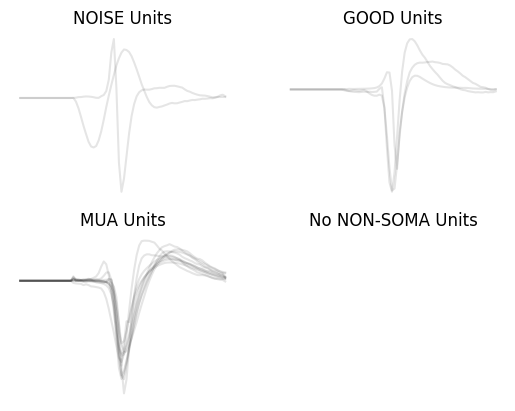

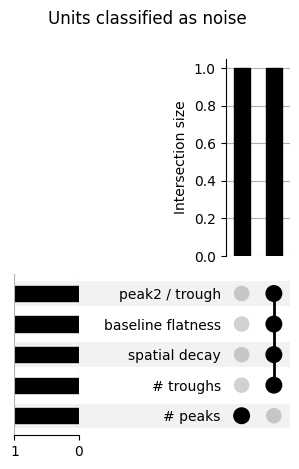

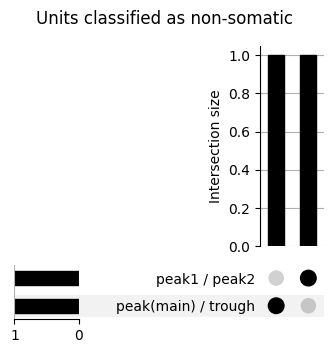

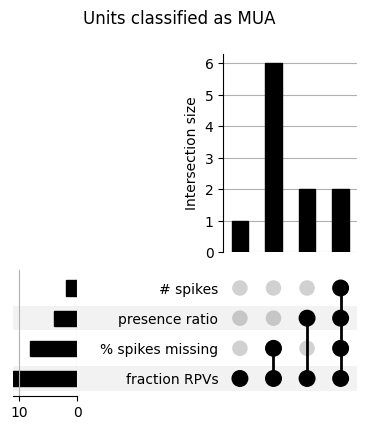

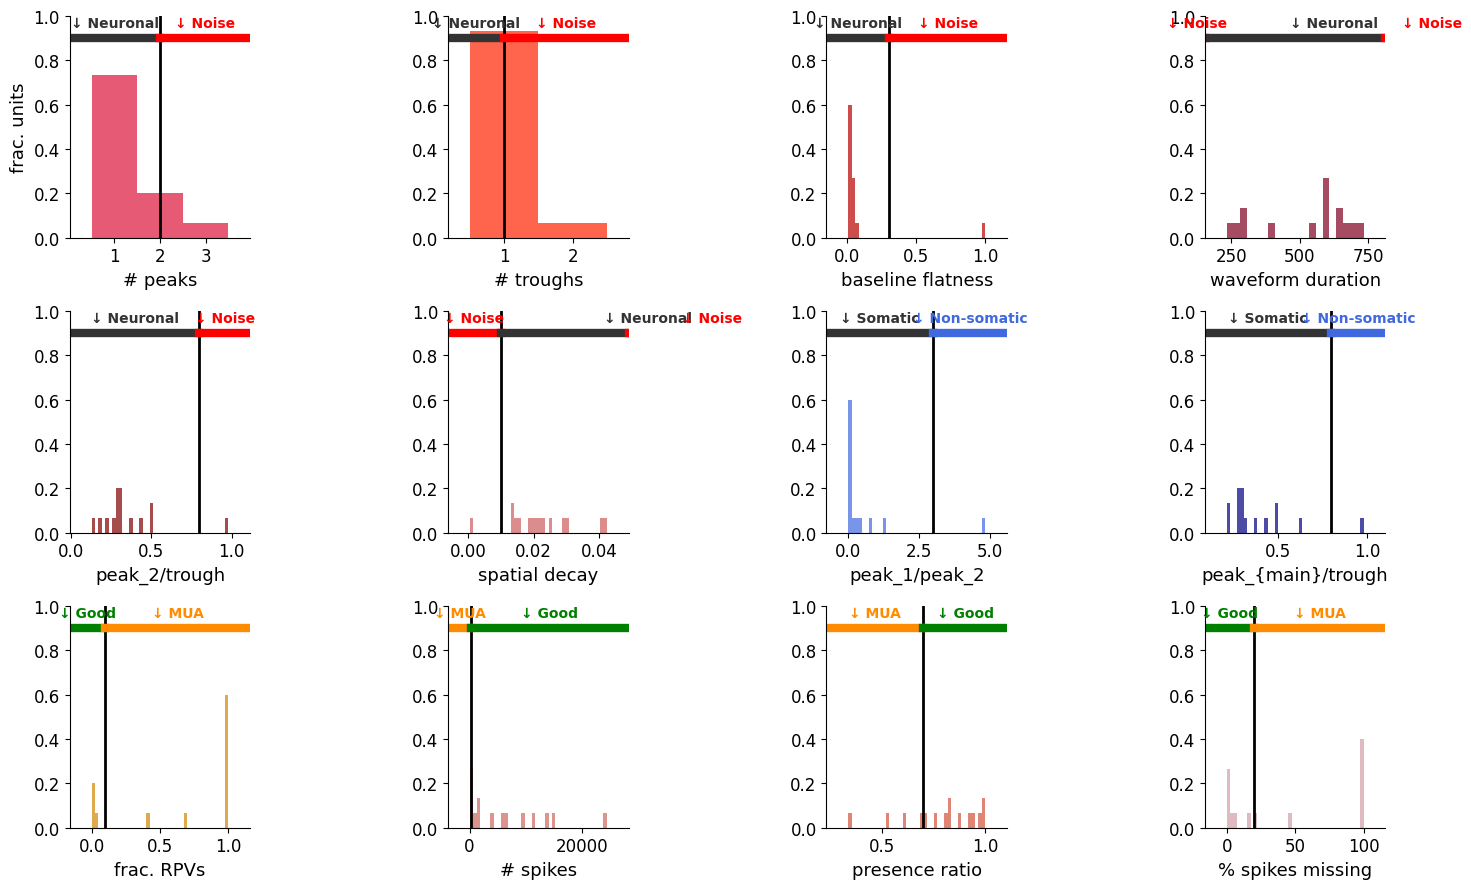


Saving results...
All expected metrics were successfully saved.


In [8]:
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)
# Use the output summary plots (below) to see if the 
# quality metric thresholds seem roughly OK for your 
# data (i.e. there isn't one threshold removing all 
# units or a threshold may below that removes none)
# more details on these output plots in the wiki:
# https://github.com/Julie-Fabre/bombcell/wiki/Summary-output-plots

##### How to access bombcell's saved quality metrics
Looking at all quality metric values per unit: 

In [9]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs_estimatedTauR,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
0,MUA,0,9705.0,1.0,1.0,600.000000,0.042352,0.021372,0.312463,0.312463,0.283650,11.282845,2.730338,7.318890,46.255808,27.709497,0.0,1.000000,0.756757,24.972344,222.087749,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,0
1,NOISE,1,24343.0,2.0,2.0,400.000000,0.000496,1.000000,0.980433,0.980433,0.387652,2.631118,NaN,6.138664,100.000000,31.484140,0.0,1.000000,1.000000,42.515827,383.897898,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,0
2,MUA,2,5906.0,1.0,1.0,733.333333,0.025323,0.048061,0.431882,0.431882,0.059760,38.745548,1.583575,8.757204,100.000000,22.074152,0.0,1.000000,0.972973,73.389266,453.775656,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,2
3,MUA,3,1342.0,1.0,1.0,300.000000,0.040807,0.014625,0.234792,0.234792,0.021125,201.614166,1.669799,4.064459,20.025744,20.872642,0.0,1.000000,0.810811,49.149593,632.523427,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,2
4,MUA,4,3784.0,2.0,1.0,600.000000,0.013389,0.057277,0.304664,0.304664,0.844419,3.887054,3.297335,8.822806,99.088750,41.360607,0.0,1.000000,0.945946,65.015079,406.069652,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,4
5,MUA,5,6454.0,1.0,1.0,666.666667,0.028866,0.044926,0.297345,0.297345,0.045485,73.939125,NaN,6.026639,6.719013,2.330508,0.0,0.982238,0.527027,34.258558,362.233033,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,6
6,GOOD,6,13605.0,1.0,1.0,266.666667,0.020930,0.026933,0.492256,0.492256,0.042574,47.715912,1.439375,4.136663,0.469969,7.139932,0.0,0.032903,0.824324,52.689211,170.088576,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,6
7,MUA,7,171.0,1.0,1.0,600.000000,0.014845,0.019374,0.288174,0.288174,0.010819,320.744934,NaN,4.049386,100.000000,35.955056,0.0,1.000000,0.689189,53.153589,702.260547,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,5
8,MUA,8,390.0,1.0,1.0,600.000000,0.015257,0.045225,0.303427,0.303427,0.014729,223.752823,NaN,5.720221,0.877078,0.000000,0.0,0.676498,0.878378,44.889622,566.454679,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,9
9,MUA,9,75.0,1.0,1.0,633.333333,0.019839,0.029477,0.292315,0.292315,0.019463,175.766403,NaN,5.589833,100.000000,30.555556,0.0,1.000000,0.337838,64.342559,393.136776,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,11


In [10]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,# peaks,# troughs,waveform duration,baseline flatness,peak2 / trough,spatial decay,# spikes,% spikes missing,presence ratio,fraction RPVs,non somatic,peak(main) / trough,peak1 / peak2
0,MUA,0,False,False,False,False,False,False,False,True,False,True,False,False,False
1,NOISE,1,False,True,False,True,True,True,False,True,False,True,True,True,False
2,MUA,2,False,False,False,False,False,False,False,True,False,True,False,False,False
3,MUA,3,False,False,False,False,False,False,False,True,False,True,False,False,False
4,MUA,4,False,False,False,False,False,False,False,True,False,True,False,False,False
5,MUA,5,False,False,False,False,False,False,False,False,True,True,False,False,False
6,GOOD,6,False,False,False,False,False,False,False,False,False,False,False,False,False
7,MUA,7,False,False,False,False,False,False,True,True,True,True,False,False,False
8,MUA,8,False,False,False,False,False,False,False,False,False,True,False,False,False
9,MUA,9,False,False,False,False,False,False,True,True,True,True,False,False,False


Example: get all quality metrics for unit 12

In [11]:
u = 12

units = quality_metrics_table.phy_clusterID
quality_metrics_table.loc[units == u, :]

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs_estimatedTauR,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
12,MUA,12,14750.0,1.0,1.0,300.0,0.013697,0.077735,0.49462,0.49462,0.088362,22.880278,1.020831,6.329063,100.0,0.0,0.0,1.0,1.0,30.6275,191.151639,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,12


#### Look at your data and bombcell's metrics in the minimal GUI

In [ ]:
# Launch minimal GUI. Currently a little slow first time around due to ACG computation
# Ideally, take a look at your units for a few datasets so you can get an idea of which 
# paramaters will work best for your purposes. 
gui = bc.unit_quality_gui(
    ks_dir=ks_dir,
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=save_path
)

Loaded GUI data from: toy_data/bombcell/for_GUI/gui_data.pkl
🚀 Auto-loaded GUI data from: toy_data/bombcell/for_GUI/gui_data.pkl
GUI data loaded successfully!
   Data types available: ['peak_locations', 'trough_locations', 'peak_loc_for_duration', 'trough_loc_for_duration', 'peak_trough_labels', 'duration_lines', 'spatial_decay_fits', 'amplitude_fits', 'channel_arrangements', 'waveform_scaling', 'acg_data', 'per_bin_metrics']
   Peak/trough detection: 15 units
   Spatial decay fits: 15 units
   Amplitude fits: 11 units
   ACG data: 15 units (computed on-demand)
Total units: 15


#### Fine-tune quality metric thresholds 
Based on bombcell's global output plots and on looking through the GUI, you can adjust any of bombcell's quality metric thresholds and which quality metrics are computed.
For instance, if you ae recording in the cerebellum and want to keep complex spikes, you might want to tweak waveform paramaters like max number of peaks and troughs to ensure you aren't classifying these units as noise. 

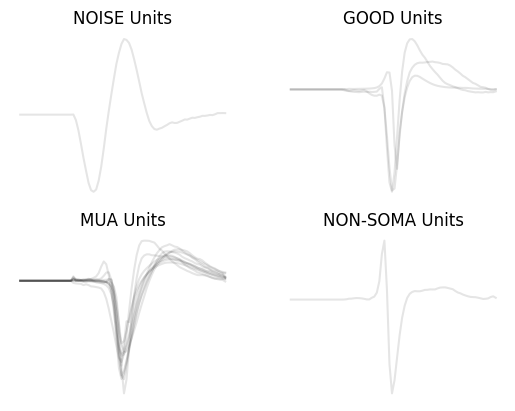

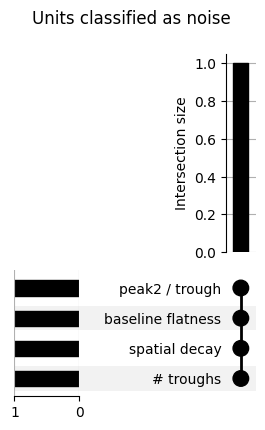

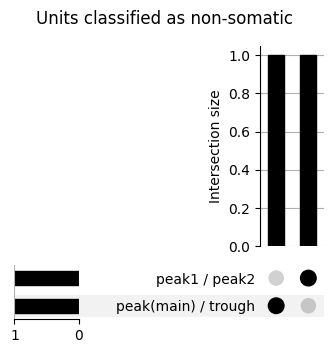

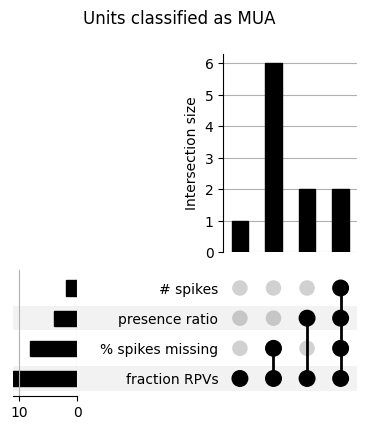

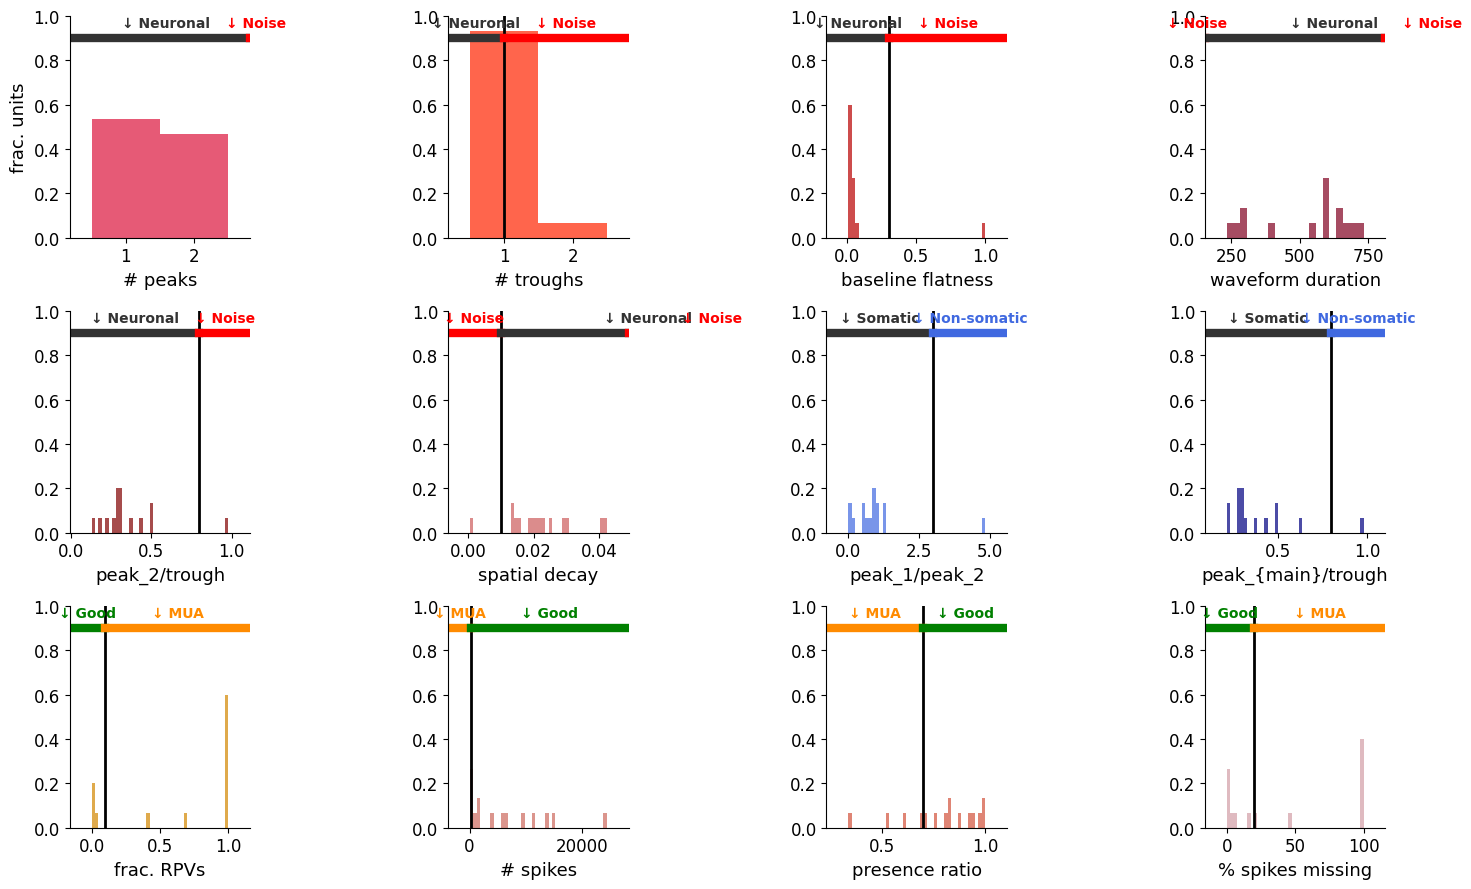

In [ ]:
# Example: how to tweak a classification threshold and replot the summary plots 

# load previously computed quality metrics
param, quality_metrics, fractions_RPVs_all_taur = bc.load_bc_results(save_path)
# change parameter of interest 
param["maxNPeaks"] = 3 # for instance, it you more atypical waveform shapes in your region of interest
# get quality unit types
unit_type, unit_type_string = bc.qm.get_quality_unit_type(
        param, quality_metrics
    ) 
# load ephys data
(
    spike_times_samples,
    spike_clusters, # actually spike_templates, but they're the same in bombcell
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)
# replot global output plots
bc.plot_summary_data(quality_metrics, template_waveforms, unit_type, unit_type_string, param)


## Ephys properties and cell type classification

Bombcell can also compute ephys properties for each unit and classify cortical and striatal neurons based on these. 

In [14]:
# Use the real dataset for ephys properties demonstration
ks_dir = "toy_data"
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: toy_data


In [15]:
# Load spike data needed for ephys properties
(
    spike_times_samples,
    spike_clusters,
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)

In [16]:
# Compute ephys properties for cell type classification
ephys_param = bc.get_ephys_parameters(ks_dir)

# Compute all ephys properties using the correct function signature
ephys_properties, ephys_param = bc.run_all_ephys_properties(ks_dir, ephys_param)

Computing ephys properties for 15 units (unit-by-unit processing)...


Computing ephys properties:   0%|          | 0/15 [00:00<?, ?it/s]

Ephys properties computation complete!
Ephys properties saved to: toy_data/templates._bc_ephysProperties.parquet
Parameters saved to: toy_data/_bc_ephysParameters.parquet


Classifying striatum neurons...


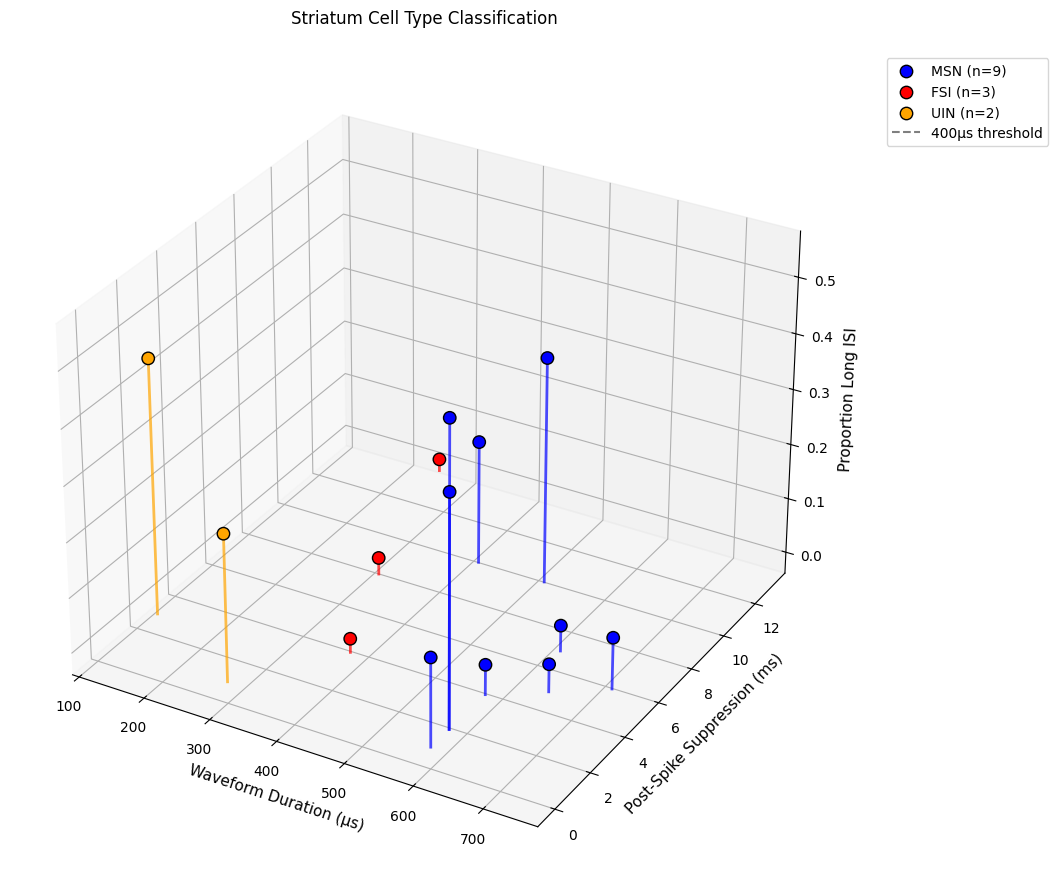

Plotted 14 units:
  Waveform duration range: 133-733 μs
  Post-spike suppression range: 0.0-13.0 ms
  Prop long ISI range: 0.021-0.541

Striatum cell type distribution:
  MSN: 9 (60.0%)
  FSI: 3 (20.0%)
  TAN: 0 (0.0%)
  UIN: 2 (13.3%)
  Unknown: 1 (6.7%)


In [17]:
# Cell type classification with automatic plot generation
# Specify brain region: 'cortex' or 'striatum'
brain_region = 'striatum'  # Change this to 'cortex' for cortical data. Striatum and cortex are the only two options for now. 

print(f"Classifying {brain_region} neurons...")
cell_types = bc.classify_and_plot_brain_region(ephys_properties, ephys_param, brain_region)

In [18]:
# Show classification results
if cell_types is not None:
    # Create combined results table
    ephys_df = pd.DataFrame(ephys_properties)
    ephys_properties_table = ephys_df.copy()
    ephys_properties_table['cell_type'] = cell_types
   
    print(ephys_properties_table)

    unit_id  postSpikeSuppression  acg_tau_rise  acg_tau_decay    isi_cv  \
0         0              0.257532           3.0    1288.367893  4.265441   
1         1              0.138375           3.0            NaN  4.797825   
2         2              0.562436           4.0            NaN  2.897528   
3         3              0.453914           1.0      12.463837  3.254744   
4         4              1.980257           0.0      56.997039  3.039968   
5         5              0.139960           3.0            NaN  5.296871   
6         6              0.009714          10.0            NaN  9.065419   
7         7              0.000000           2.0       4.266439  1.829375   
8         8              0.827703           3.0      53.264784  2.286946   
9         9                   NaN           NaN            NaN       NaN   
10       10              0.000000           1.0       4.479466  3.931697   
11       11              0.000000           8.0            NaN  3.275890   
12       12 